### Install segmentation-models-pytorch

In [1]:
!pip install segmentation-models-pytorch
!pip install torchmetrics
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 19.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 26.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=e935270cccbf07265cd4dd716f20ed582999b550a9bc79981c01126f62dec7df
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=6d8350f4d12a598a867afc10a30b1f19bc7b6e859f6090a42c323432e1c7d0fa
  Stored in directory: /root/.cache/pip/w

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Unzip dataset from drive

In [3]:
!unzip '/content/drive/MyDrive/dataset-reduced.zip'

Streaming output truncated to the last 5000 lines.
  inflating: dataset-reduced/train/Septoria Leaf Spot/3a1f89c1-9f3b-47ec-aafc-7f2ba2558d6d___Matt.S_CG 6856_flipTB.JPG  
  inflating: dataset-reduced/train/Septoria Leaf Spot/badbd0d4-8e02-49bf-a042-87ae373ca66f___Matt.S_CG 6741.JPG  
  inflating: dataset-reduced/train/Septoria Leaf Spot/e38e01c9-c22c-41d9-9391-7f0227cfc666___Matt.S_CG 1373.JPG  
  inflating: dataset-reduced/train/Septoria Leaf Spot/Gls64_change_90.jpg  
  inflating: dataset-reduced/train/Septoria Leaf Spot/13d82f96-ac84-4176-abf9-f1fbaac4aabd___Matt.S_CG 0989.JPG  
  inflating: dataset-reduced/train/Septoria Leaf Spot/1c7e9ef5-bf97-4e53-b6c1-7fd148d043d5___Matt.S_CG 6482_180deg.JPG  
  inflating: dataset-reduced/train/Septoria Leaf Spot/1c7bc7c5-daec-45bd-beb9-89beb159c755___Keller.St_CG 2018_180deg.JPG  
  inflating: dataset-reduced/train/Septoria Leaf Spot/1f6955e1-0c57-45ef-a769-8578aa3425d6___JR_Sept.L.S 8502_180deg.JPG  
  inflating: dataset-reduced/train/Septori

### Imports and Assign gpu device

In [4]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from PIL import Image
import segmentation_models_pytorch as smp
import torchmetrics as tm

In [ ]:
classification_models = torchvision.models.list_models(module=torchvision.models)

print(classification_models)

['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'googlenet', 'inception_v3', 'maxvit_t', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext101_64x4d', 'resnext50_32x4d', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_v2_x2_0', 'squeezenet1_0

In [5]:
# check GPU availability
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name(device))
else:
    device = torch.device('cpu')
    print('GPU is not available')

Tesla T4


### Load Dataset

Number of training images: 21257
Number of validation images: 5534
Class names: ['Bacterial Spot', 'Early Blight', 'Healthy', 'Late Blight', 'Leaf Mold', 'Septoria Leaf Spot', 'Tomato Mosaic Virus', 'Yellow Leaf Curl Virus']
0
<class 'torch.Tensor'>
torch.Size([3, 512, 512])
{'Bacterial Spot': 0, 'Early Blight': 1, 'Healthy': 2, 'Late Blight': 3, 'Leaf Mold': 4, 'Septoria Leaf Spot': 5, 'Tomato Mosaic Virus': 6, 'Yellow Leaf Curl Virus': 7}
8


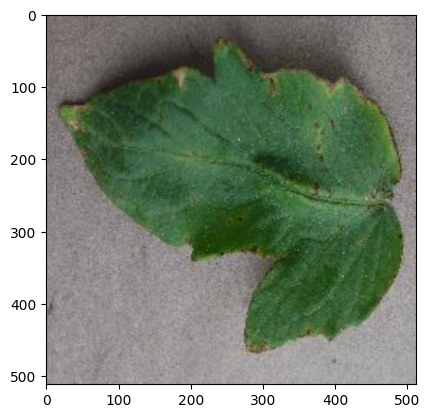

In [14]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Define the path to the dataset directory
data_dir = '/content/dataset-reduced'

# Define the transforms to apply to the images
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the training set
train_set = datasets.ImageFolder(root=f'{data_dir}/train', transform=transform)

# Load the validation set
valid_set = datasets.ImageFolder(root=f'{data_dir}/valid', transform=transform)

# Print the number of images in each set
print(f"Number of training images: {len(train_set)}")
print(f"Number of validation images: {len(valid_set)}")

# Print the class names
class_names = train_set.classes
print(f"Class names: {class_names}")

image, label = train_set[1]
plt.imshow(np.transpose(image, (2,1,0)))
print(label)
print(type(image))
print(image.shape)

print(train_set.class_to_idx)

# image = torchvision.io.read_image('/content/drive/MyDrive/COCOdatasettomato/images/train/Tomato-diseases-prevention-treatment--Early-blight-_jpg.rf.218d855be5666cc2019881969d402d66.jpg')
# segmented = model(torch.unsqueeze(image, 0))
# plt.imshow(np.transpose(segmented.cpu().squeeze(0), (2,1,0)))

# num classes
num_classes = len(train_set.classes)
print(num_classes)


# Create a DataLoader object for the training set
batch_size = 8
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=2)


### Define Models

In [15]:
import torch.nn as nn

class SegmentationModel(nn.Module):
    def __init__(self, seg_path):
        super().__init__()
        # Define your segmentation model here
        # self.segmentation = models.segmentation.__dict__["fcn_resnet50"](pretrained=True)
        self.segmentation = torch.load(seg_path, map_location=torch.device(device))
        # Freeze the segmentation layers
        for param in self.segmentation.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Forward pass through the segmentation model
        # x = x/255.0
        # resize
        x = torchvision.transforms.Resize(size=(512,512))(x)
        if x.shape[1] == 4:
          # if batch_size is 1
          if x.shape[0] == 1:
            img = x.squeeze(0)
            # transpose to shape: 512, 512, 4
            img = np.transpose(img, (1,2,0))
            pil_image = Image.fromarray(img.numpy(), 'RGBA')
            rgb_image = pil_image.convert('RGB')
            rgb_array = np.asarray(rgb_image, dtype=np.float32)
            x = torch.from_numpy(np.transpose(rgb_array, (2,1,0)))
            x = x.unsqueeze(0)
        x = x.to(device=device)
        # print(np.unique(x.cpu()))
        # return x
        # segment image first
        outputs = self.segmentation(x)
        # Apply softmax activation function to the output
        probs = torch.softmax(outputs, dim=1)
        # Get the predicted labels
        _, labels = torch.max(probs, dim=1)

        disease_mask = (labels == 2).float()
        disease_mask = torch.unsqueeze(disease_mask, 1)
        healthy_mask = (labels == 1).float()
        healthy_mask = torch.unsqueeze(healthy_mask, 1)
        leaf_mask = disease_mask + healthy_mask

        disease = x * disease_mask
        leaf = x * leaf_mask
        return (leaf, disease)

class ClassificationModel(nn.Module):
    def __init__(self, classification_model=torchvision.models.resnet18(pretrained=True), num_classes=8):
        super().__init__()
        self.label_dict = train_set.class_to_idx
        # below for resnet18
        # Define your classification model here
        self.classification = classification_model
        # Replace the last layer with a new layer that has num_classes outputs
        num_features = self.classification.fc.in_features
        self.classification.fc = nn.Linear(num_features, num_classes)

        # for efficientnet
        # self.classification = classification_model(pretrained=False, num_classes=num_classes)
        
    
    def forward(self, x):
        # Forward pass through the classification model
        x = self.classification(x)
        return x


class DiseaseClassifierModel(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        self.label_dict = train_set.class_to_idx
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classification = nn.Sequential(
            nn.Linear(64*64*64, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        # Forward pass through the feature extraction layers
        x = self.features(x)
        # Flatten the output tensor before feeding it into the classification layers
        x = x.view(x.size(0), -1)
        # Forward pass through the classification layers
        x = self.classification(x)
        return x

### Instantiation of Segmentation Model

In [16]:
def show_seg_predictions(images, model):
    model.eval() # set the model to evaluation mode
    with torch.no_grad(): # turn off gradient computation
        # get the model predictions
        leaf, disease = model(images)

    # convert tensors to numpy arrays
    images = images.cpu().numpy()
    preds = disease.cpu().numpy()

    # plot the original images and predicted masks side by side
    batch_size = images.shape[0]
    for i in range(batch_size):
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(images[i].transpose(2, 1, 0))
        axs[0].set_title('Original Image')
        axs[1].imshow(np.transpose(preds[i], (2,1,0)))
        axs[1].set_title('Predicted Mask')
        plt.show()

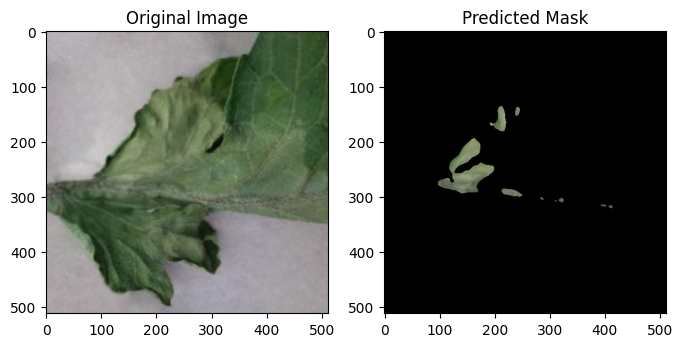

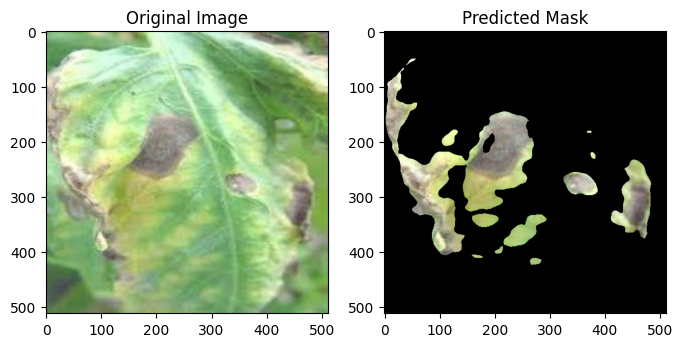

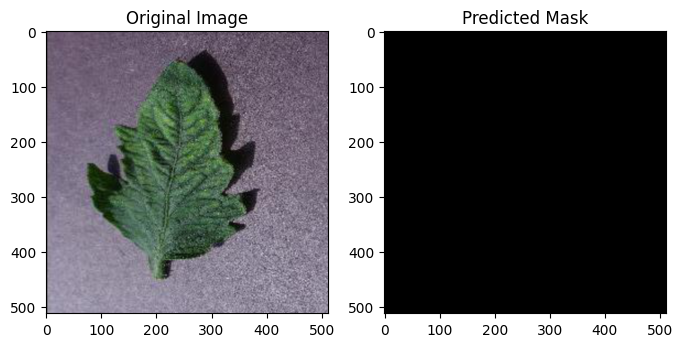

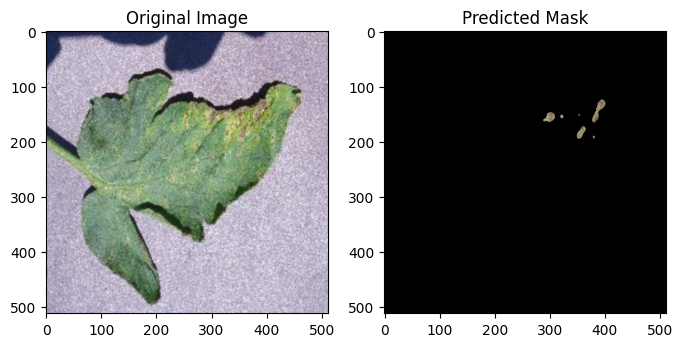

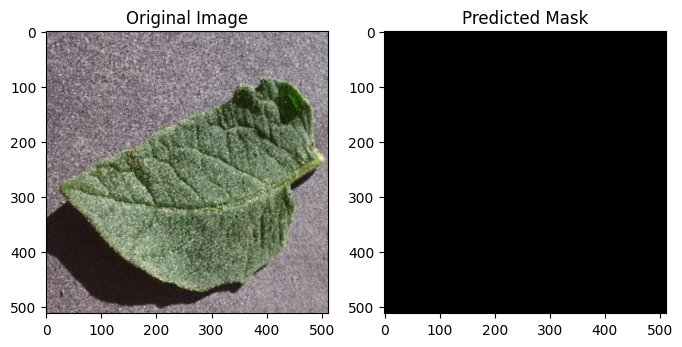

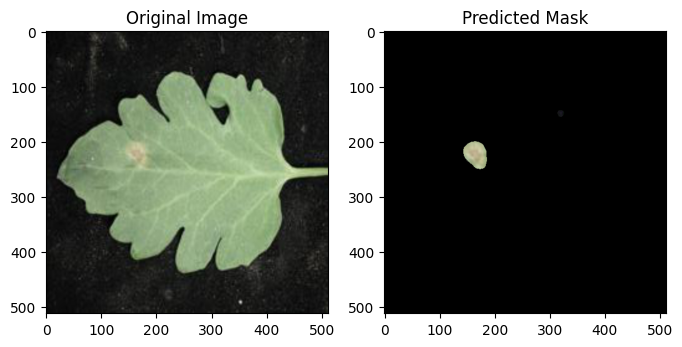

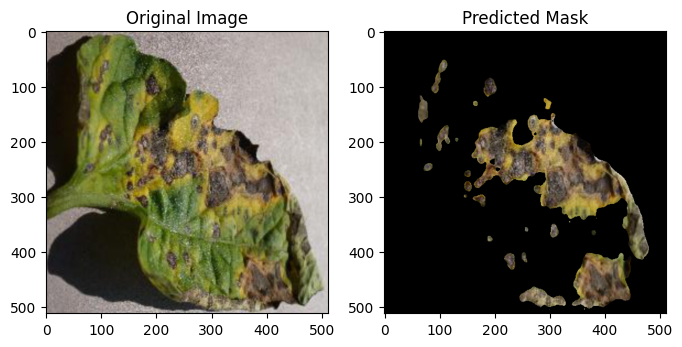

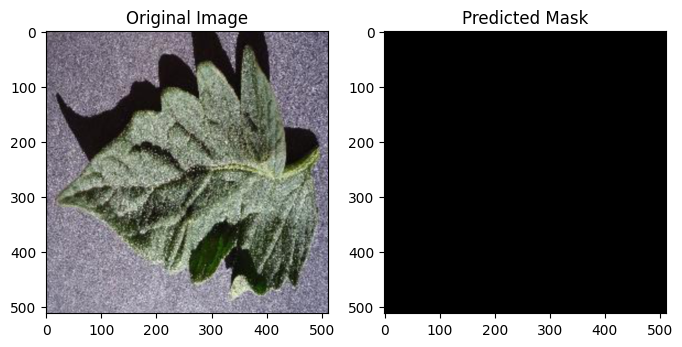

In [17]:
# fig, axs = plt.subplots(1, 2, figsize=(8, 4))

segmentation_model = SegmentationModel('/content/drive/MyDrive/saved_seg_models/mobilenetv3')

# path = '/content/drive/MyDrive/COCOdatasettomato/images/val/web1_copy_tomato-septoria-leaf-spot4_jpg.rf.8f5314d83cb70da4551d2c6df8f6a98f.jpg'
# img = torchvision.io.read_image(path)


imgs, labels = next(iter(train_loader))
img = imgs[0]


# # plot the first image in the left subplot
# axs[0].imshow(np.transpose(img, (2,1,0)))
# axs[0].set_title('Image 1')

# img = torch.unsqueeze(img, 0)

# disease = model(img)
# # print(np.unique(disease.cpu()))

# axs[1].imshow(np.transpose(disease.cpu().squeeze(0), (2,1,0)))
# axs[1].set_title('Image 2')

# # display the figure
# plt.show()

show_seg_predictions(imgs, segmentation_model)


### Instantiate Classification model and test its output.

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Prediction:  Bacterial Spot
True:  Bacterial Spot
tensor([0], device='cuda:0')


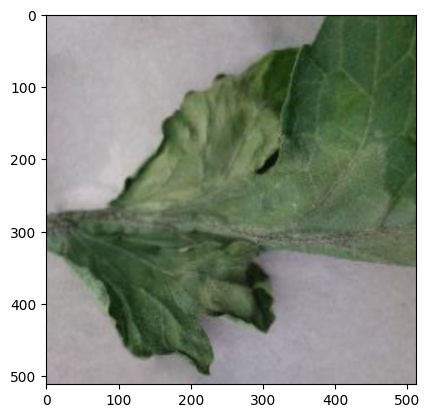

In [18]:
classification_model = ClassificationModel(classification_model=torchvision.models.resnet18(pretrained=False))
# classification_model = DiseaseClassifierModel()
classification_model = classification_model.to(device)
classification_model.train(mode=False)

plt.imshow(np.transpose(img, (2,1,0)))
outputs = classification_model(img.unsqueeze(0).to(device))

probabilities = torch.softmax(outputs, dim=1)
predicted_class = torch.argmax(probabilities, dim=1)

# label_dict = classification_model.label_dict
label_dict = train_set.class_to_idx
def get_class_from_id(id):
  label = list(label_dict.keys())[list(label_dict.values()).index(id)]
  return label

print("Prediction: ", get_class_from_id(predicted_class.cpu().numpy()[0]))

print("True: ", get_class_from_id(label))

print(predicted_class)

# Train Model

In [ ]:
'''
Move to GPU
'''
classification_model = classification_model.to(device)
segmentation_model = segmentation_model.to(device)

'''
Optimizer, loss function and metric
'''
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(classification_model.parameters(), lr=0.001)
confusion_matrix = tm.classification.MulticlassStatScores(num_classes=8, average='none').to(device)


'''
Helper functions
'''
# return class name from id
def get_class_from_id(id):
  label = list(label_dict.keys())[list(label_dict.values()).index(id)]
  return label

# print precision and recall
def print_precision_recall(precision, recall, mode='Val'):
  label_dict = classification_model.label_dict
  for i in range(len(label_dict)):
    print(f"{get_class_from_id(i)} - {mode} Precision: {precision[i]:.4f} - {mode} Recall: {recall[i]:.4f}")

# print all metrics and return precision, recall and accuracy
def get_metrics(confusion_matrix):
  print('       TP      FP      TN       FN  ')
  for class_number, (stat) in enumerate(confusion_matrix):
    tp = stat[0].cpu().numpy()
    fp = stat[1].cpu().numpy()
    tn = stat[2].cpu().numpy()
    fn = stat[3].cpu().numpy()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    print(f'{class_number}:     {tp}     {fp}     {tn}     {fn}     Precision: {precision} | Recall: {recall}')
    totals = sum(confusion_matrix)
    total_precision = totals[0]/(totals[0]+totals[1])
    total_recall = totals[0]/(totals[0]+totals[4])
    total_accuracy = (totals[0]+totals[2])/(totals[0]+totals[1]+totals[2]+totals[3])
  print('Total Precision: ', total_precision)
  print('Total Recall: ', total_recall)
  print('Total Accuracy: ', total_accuracy)
  return (total_precision.item(), total_recall.item(), total_accuracy.item())

'''
Lists to be used in plots
'''
train_loss_list = []
val_loss_list = []
train_p_list = []
train_r_list = []
train_a_list = []
val_p_list = []
val_r_list = []
val_a_list = []


'''
Training Loop
'''
stopping_point = 15
num_epochs = 10
for epoch in range(num_epochs):

    # init stats
    total_train_loss = 0
    train_preds = []
    train_labels = []
    train_confusion_matrix = torch.tensor([
        [0,0,0,0,0],
        [0,0,0,0,0],
        [0,0,0,0,0],
        [0,0,0,0,0],
        [0,0,0,0,0],
        [0,0,0,0,0],
        [0,0,0,0,0],
        [0,0,0,0,0],
    ]).to(device)
    valid_confusion_matrix = torch.tensor([
        [0,0,0,0,0],
        [0,0,0,0,0],
        [0,0,0,0,0],
        [0,0,0,0,0],
        [0,0,0,0,0],
        [0,0,0,0,0],
        [0,0,0,0,0],
        [0,0,0,0,0],
    ]).to(device)


    # set trainable
    classification_model.train(mode=True)
    print(epoch)
    for i, (images, labels) in enumerate(train_loader):
        # if i > stopping_point:
        #   break
        # Perform segmentation on the input images
        leaf, disease = segmentation_model(images)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = classification_model(disease.to(device))
        train_loss = criterion(outputs, labels.to(device))

        # Backward pass and optimization
        train_loss.backward()
        optimizer.step()


        # calculate training statistics
        total_train_loss += train_loss.item() * images.size(0)

        probabilities = torch.softmax(outputs, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)
        stat = confusion_matrix(predicted_classes, labels.to(device))
        train_confusion_matrix = torch.add(train_confusion_matrix, stat)

        # Print statistics
        # if (i + 1) % 10 == 0:
        #     print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, len(train_loader), train_loss.item()))
    
    # calculate training accuracy and print metrics
    total_train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {total_train_loss:.4f}")
    p, r, a = get_metrics(train_confusion_matrix)
    # append to lists
    train_loss_list.append(total_train_loss)
    train_p_list.append(p)
    train_r_list.append(r)
    train_a_list.append(a)


    '''
    Validation
    '''
    # init val stats
    total_val_loss = 0
    val_preds = []
    val_labels = []

    classification_model.train(mode=False)
    print("Validation")
    for i, (images, labels) in enumerate(val_loader):
        # if i > stopping_point:
        #   break
        # Perform segmentation on the input images
        leaf, disease = segmentation_model(images)

        # Forward pass
        outputs = classification_model(disease.to(device))
        val_loss = criterion(outputs, labels.to(device))


        # calculate validation statistics
        total_val_loss += val_loss.item() * images.size(0)

        probabilities = torch.softmax(outputs, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)
        stat = confusion_matrix(predicted_classes, labels.to(device))
        valid_confusion_matrix = torch.add(valid_confusion_matrix, stat)

        # Print statistics
        # if (i + 1) % 10 == 0:
        #     print('Epoch [{}/{}], Step [{}/{}], Val Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, len(val_loader), val_loss.item()))
    
    # calculate validation accuracy and print metrics
    total_val_loss /= len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Val Loss: {val_loss:.4f}")
    p, r, a = get_metrics(valid_confusion_matrix)
    # append to lists
    val_loss_list.append(total_val_loss)
    val_p_list.append(p)
    val_r_list.append(r)
    val_a_list.append(a)


0
Epoch 1/10 - Train Loss: 1.5779
       TP      FP      TN       FN  
0:     388     1333     17098     2438     Precision: 0.22545031958163858 | Recall: 0.1372965322009908
1:     1012     1098     17707     1440     Precision: 0.47962085308056873 | Recall: 0.41272430668841764
2:     2666     3318     14891     382     Precision: 0.4455213903743315 | Recall: 0.8746719160104987
3:     1528     1539     16605     1585     Precision: 0.49820671666123245 | Recall: 0.4908448442017347
4:     901     1447     17062     1847     Precision: 0.38373083475298125 | Recall: 0.32787481804949054
5:     1249     1636     16740     1632     Precision: 0.43292894280762567 | Recall: 0.43353002429711907
6:     418     932     18172     1735     Precision: 0.30962962962962964 | Recall: 0.19414770088248956
7:     831     961     18260     1205     Precision: 0.46372767857142855 | Recall: 0.4081532416502947
Total Precision:  tensor(0.4231, device='cuda:0')
Total Recall:  tensor(0.2973, device='cuda:0')
Tota

### Plot losses

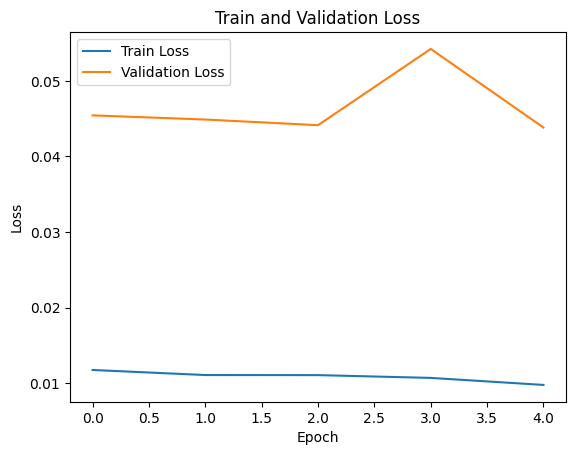

In [ ]:
import matplotlib.pyplot as plt

# Plot the train and validation loss curves
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

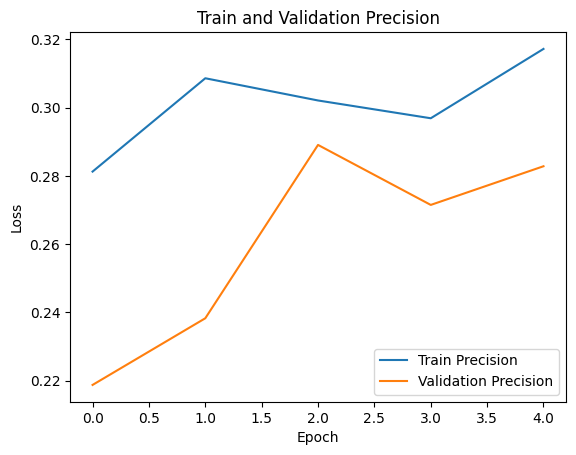

In [ ]:
# Plot the train and validation precision curves
plt.plot(train_p_list, label='Train Precision')
plt.plot(val_p_list, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Precision')
plt.legend()
plt.show()

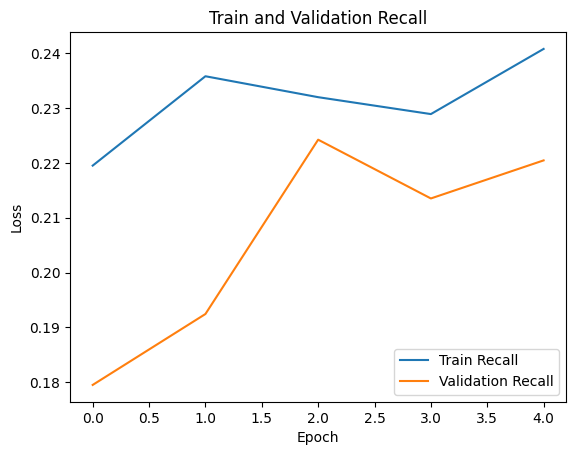

In [ ]:
plt.plot(train_r_list, label='Train Recall')
plt.plot(val_r_list, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Recall')
plt.legend()
plt.show()

### Save Model Weights

In [ ]:
torch.save(classification_model, '/content/drive/MyDrive/classification-v4')
torch.save(segmentation_model, '/content/drive/MyDrive/segmentation-v4')
torch.save(classification_model.state_dict(), '/content/drive/MyDrive/classification-v4_stateDict')
torch.save(segmentation_model.state_dict(), '/content/drive/MyDrive/segmentation-v4_stateDict')

### Testing

tensor([2], device='cuda:0')
{'Bacterial Spot': 0, 'Early Blight': 1, 'Healthy': 2, 'Late Blight': 3, 'Leaf Mold': 4, 'Septoria Leaf Spot': 5, 'Tomato Mosaic Virus': 6, 'Yellow Leaf Curl Virus': 7}
Prediction:  Healthy
True:  Healthy


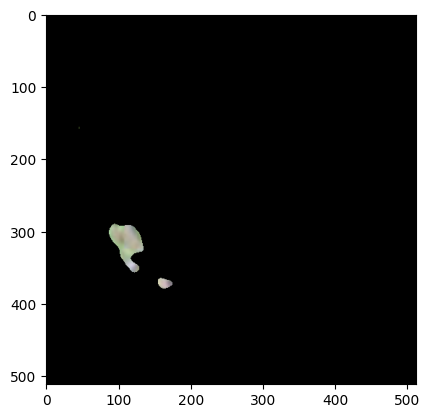

In [ ]:
imgs, labels = next(iter(val_loader))
img = imgs[0]
label = labels[0]
plt.imshow(np.transpose(img, (2,1,0)))

# segment image
leaf, disease = segmentation_model(img.unsqueeze(0).to(device))
plt.imshow(np.transpose(disease.squeeze(0).cpu(), (2,1,0)))

# classify
# outputs = classification_model(img.unsqueeze(0).to(device))
outputs = classification_model(disease)

probabilities = torch.softmax(outputs, dim=1)
predicted_class = torch.argmax(probabilities, dim=1)
print(predicted_class)

print(train_set.class_to_idx)

# label_dict = train_set.class_to_idx
label_dict = classification_model.label_dict
def get_class_from_id(id):
  label = list(label_dict.keys())[list(label_dict.values()).index(id)]
  return label

print("Prediction: ", get_class_from_id(predicted_class.cpu().numpy()[0]))

print("True: ", get_class_from_id(label))


### Test on other image

torch.Size([1, 4, 562, 250])
torch.Size([1, 4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([1, 3, 512, 512])


tensor([2], device='cuda:0')
{'Bacterial Spot': 0, 'Early Blight': 1, 'Healthy': 2, 'Late Blight': 3, 'Leaf Mold': 4, 'Septoria Leaf Spot': 5, 'Tomato Mosaic Virus': 6, 'Yellow Leaf Curl Virus': 7}
Prediction:  Healthy
True:  Bacterial Spot


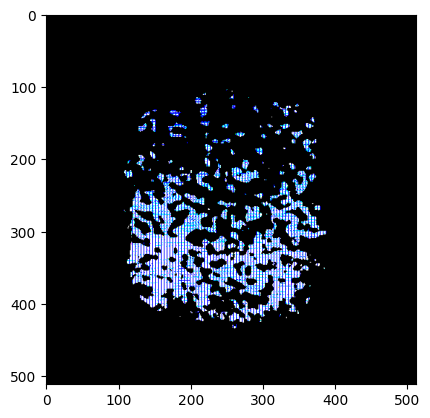

In [ ]:
img = torchvision.io.read_image('/content/sample_data/imagescropped.png')
img = torch.from_numpy(np.array(img, dtype=np.float32))



# segment image
leaf, disease = segmentation_model(img.unsqueeze(0))
plt.imshow(np.transpose(disease.squeeze(0).cpu(), (2,1,0)))

# classify
# outputs = classification_model(img.unsqueeze(0).to(device))
outputs = classification_model(disease)

probabilities = torch.softmax(outputs, dim=1)
predicted_class = torch.argmax(probabilities, dim=1)
print(predicted_class)

print(train_set.class_to_idx)

# label_dict = train_set.class_to_idx
label_dict = classification_model.label_dict
def get_class_from_id(id):
  label = list(label_dict.keys())[list(label_dict.values()).index(id)]
  return label

print("Prediction: ", get_class_from_id(predicted_class.cpu().numpy()[0]))

print("True: ", get_class_from_id(label))

## Evaluate Saved Model

### Load Model

In [11]:
'''
Classification
'''
classification_model = ClassificationModel()
weights_path = '/content/drive/MyDrive/classification-v3_stateDict'
classification_model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))
classification_model.train(mode=False)
classification_model = classification_model.to(device)
'''
Segmentation
'''
segmentation_model = SegmentationModel('/content/drive/MyDrive/saved_seg_models/mobilenetv3')
segmentation_model = segmentation_model.to(device)

In [12]:
def get_class_from_id(id):
  label = list(label_dict.keys())[list(label_dict.values()).index(id)]
  return label

tp_arr = [0,0,0,0,0,0,0,0]
fp_arr = [0,0,0,0,0,0,0,0]

total_stat = torch.from_numpy(np.zeros_like([
    [0,0,0,0,0],
    [0,0,0,0,0],
    [0,0,0,0,0],
    [0,0,0,0,0],
    [0,0,0,0,0],
    [0,0,0,0,0],
    [0,0,0,0,0],
    [0,0,0,0,0],
])).to(device)

for i, (images, labels) in enumerate(val_loader):
  # Perform segmentation on the input images
  images = images.to(device)
  labels = labels.to(device)
  leaf, disease = segmentation_model(images)
  # Forward pass
  outputs = classification_model(disease.to(device))
  # get predicted id
  probabilities = torch.softmax(outputs, dim=1)
  predicted_classes = torch.argmax(probabilities, dim=1)
  '''
  Compute Metrics
  '''
  confusion_matrix = tm.classification.MulticlassStatScores(num_classes=8, average='none').to(device)
  stat = confusion_matrix(predicted_classes, labels)
  total_stat = torch.add(total_stat, stat)
  '''
  Manual counting
  '''
  # count = 0
  # for pred, true in zip(predicted_classes, labels):
  #   pred = pred.item()
  #   true = true.item()
  #   if (pred == true):
  #     count += 1
  #     tp_arr[true] += 1
  #   else:
  #     fp_arr[true] += 1
  # print(count)

In [13]:
def get_metrics(confusion_matrix):
  print('       TP      FP      TN       FN  ')
  for class_number, (stat) in enumerate(confusion_matrix):
    tp = stat[0].cpu().numpy()
    fp = stat[1].cpu().numpy()
    tn = stat[2].cpu().numpy()
    fn = stat[3].cpu().numpy()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    print(f'{class_number}:     {tp}     {fp}     {tn}     {fn}     Precision: {precision} | Recall: {recall}')
    totals = sum(total_stat)
    total_precision = totals[0]/(totals[0]+totals[1])
    total_recall = totals[0]/(totals[0]+totals[4])
    total_accuracy = (totals[0]+totals[2])/(totals[0]+totals[1]+totals[2]+totals[3])
  print('Total Precision: ', total_precision)
  print('Total Recall: ', total_recall)
  print('Total Accuracy: ', total_accuracy)
  return (total_precision.item(), total_recall.item(), total_accuracy.item())

# for c, (_tp, _fp) in enumerate(zip(tp, fp)):
#   percent = _tp/(_tp+_fp)
#   print(f'Class {c}: {_tp} Correct Predictions | {_fp} False Predictions | {percent}')

print(train_set.class_to_idx)
p, r, a = get_metrics(total_stat)




{'Bacterial Spot': 0, 'Early Blight': 1, 'Healthy': 2, 'Late Blight': 3, 'Leaf Mold': 4, 'Septoria Leaf Spot': 5, 'Tomato Mosaic Virus': 6, 'Yellow Leaf Curl Virus': 7}
       TP      FP      TN       FN  
0:     246     279     4523     486     Precision: 0.4685714285714286 | Recall: 0.3360655737704918
1:     385     119     4772     258     Precision: 0.7638888888888888 | Recall: 0.5987558320373251
2:     557     402     4331     244     Precision: 0.5808133472367049 | Recall: 0.6953807740324595
3:     378     75     4667     414     Precision: 0.8344370860927153 | Recall: 0.4772727272727273
4:     577     338     4458     161     Precision: 0.6306010928961748 | Recall: 0.7818428184281843
5:     559     655     4133     187     Precision: 0.46046128500823724 | Recall: 0.7493297587131368
6:     223     100     4850     361     Precision: 0.6904024767801857 | Recall: 0.3818493150684932
7:     371     270     4766     127     Precision: 0.5787831513260531 | Recall: 0.7449799196787149
To